
### 动手搭建卷积网络，从0到1

In [1]:
import torchvision.datasets as datasets
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
#from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.optim as optim
import torch
import matplotlib.pyplot as plt

In [2]:

#data transform 
data_transform = transforms.Compose([
    transforms.ToTensor(),#to tensor 两个操作 224 224 3 变为 3 224 224 
    transforms.Resize(size=(224,224))
])


In [3]:
data_path = './data/'
dataset = datasets.ImageFolder(root=data_path, transform=data_transform)

### 通过如下方式 认识数据集
```python
print(dataset.imgs[0])#读取路径
print(dataset[249][1])#通过这个可以索引第一张照片
```

In [4]:
for i in range(10):
    print(dataset.imgs[i])

('./data/rock\\1.jpg', 0)
('./data/rock\\133.jpg', 0)
('./data/rock\\147.jpg', 0)
('./data/rock\\152.jpg', 0)
('./data/rock\\165.jpg', 0)
('./data/rock\\168.jpg', 0)
('./data/rock\\182.jpg', 0)
('./data/rock\\186.jpg', 0)
('./data/rock\\193.jpg', 0)
('./data/rock\\206.jpg', 0)


**tips** 通过如下方式可以构建训练和测试数据集
- train_data 是可迭代对象，可以通过for i 读取其中的data和lable

In [5]:
#random_split函数来自utils，
train_data, test_data = random_split(dataset=dataset,lengths=[int(250*0.8),  len(dataset)-int(250*0.8)])
rock = 0
scissors = 0
for x,y in train_data:
    if y == 1:
        rock += 1
    else:
        scissors += 1
print(rock,scissors)



98 102


In [6]:
for i,data in enumerate(train_data):
    if i % 20 == 0:
        index = train_data.indices[i]
        print(i, data[1], index, dataset.imgs[index])

0 0 21 ('./data/rock\\286.jpg', 0)
20 1 206 ('./data/scissors\\631.jpg', 1)
40 0 20 ('./data/rock\\285.jpg', 0)
60 0 90 ('./data/rock\\764.jpg', 0)
80 0 96 ('./data/rock\\784.jpg', 0)
100 1 233 ('./data/scissors\\800.jpg', 1)
120 0 108 ('./data/rock\\88.jpg', 0)
140 1 139 ('./data/scissors\\169.jpg', 1)
160 1 188 ('./data/scissors\\534.jpg', 1)
180 1 147 ('./data/scissors\\223.jpg', 1)


(224, 224, 3)


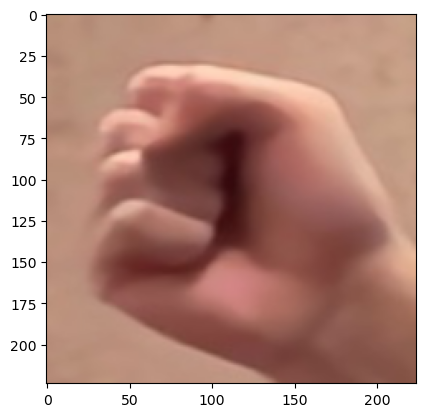

In [7]:
import numpy as np
def imshow(inp):
    '''
    Imshow for Tensor.
    :param inp:
    :return:
    '''
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    print(inp.shape)
    plt.imshow(inp)
imshow(dataset[5][0])

- 设置训练和测试加载器

In [8]:
batchsize = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,num_workers=8)
test_loader = DataLoader(test_data,batch_size=batchsize, shuffle=False, num_workers=8)

- 自定义网络结构
    - 注意bn的使用方式
    - 注意dropout的使用方式
    - 注意model.eval()的影响

In [9]:
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 2, padding=1)#112
        self.conv2 = nn.Conv2d(16, 16, 3, 2, padding=1)#56
        self.conv3 = nn.Conv2d(16, 32, 3, 2, padding=1)#28
        self.conv4 = nn.Conv2d(32, 64, 3, 2, padding=1)#14
        self.fc1 = nn.Linear(64 * 14 * 14, 1200) # conv3的输出为64 * 14 * 14
        self.fc2 = nn.Linear(1200, 512)
        self.fc3 = nn.Linear(512, 2) # 输出Tensor尺寸[batch, 1, 1, nclass]

        #self.dropout = nn.Dropout(0.7)
       
    def forward(self, x):
        x = F.relu((self.conv1(x)))
        x = F.relu((self.conv2(x)))
        x = F.relu((self.conv3(x)))
        x = F.relu((self.conv4(x)))
        x = x.view(-1, 64 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
net = Net()#实例化网络

In [11]:
net.cuda()#如果本地没有gpu 注释词句
net.eval()
data = train_data[0][0]
data = data.unsqueeze(0)
print(data.shape)
out = net(data.cuda())
out,train_data[0][1]

torch.Size([1, 3, 224, 224])


(tensor([[0.0102, 0.0078]], device='cuda:0', grad_fn=<AddmmBackward0>), 0)

In [12]:
criterion = nn.CrossEntropyLoss()#设置损失函数
criterion.to('cuda')#如果本地cpu ，注释掉此句
optimizer = optim.SGD(net.parameters(), lr = 0.001)#设置优化器
print(f"######:{optimizer.param_groups[0]['lr']}")

######:0.001


In [13]:
train_curve = list()
valid_curve = list()
log_interval = 10
val_interval = 10
MAX_EPOCH = 10
for epoch in range(MAX_EPOCH):

    loss_mean = 0.
    correct = 0.
    total = 0.

    net.train()

    for i, (data, tar) in enumerate(train_loader):

        # forward
        inputs, labels = data.to('cuda'), tar.to('cuda')
        outputs = net(inputs)

        # backward
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()

        # update weights
        optimizer.step()

        # 统计分类情况
        _, predicted = torch.max(outputs.data, 1)#返回最大值的值和下标，索引给到predicted
        #(outputs.data)#二维tensor shape （128，2）
        total += labels.size(0)
        correct += (predicted == labels).squeeze().sum().cpu().numpy()

        # 打印训练信息
        loss_mean += loss.item()
        train_curve.append(loss.item())
        if (i+1) % log_interval == 0:
            loss_mean = loss_mean / log_interval
            print("Training:Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f} Acc:{:.2%}"
                .format(epoch, MAX_EPOCH, i+1, len(train_loader), loss_mean, correct / total))
            loss_mean = 0.
    correct_val = 0.
    total_val = 0.
    loss_val = 0.
    net.eval()
    with torch.no_grad():
        for j, (data,tar) in enumerate(test_loader):
            inputs, labels = data.to('cuda'), tar.to('cuda')
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            # if(j == 0):
            #     print((predicted == labels))
            #     print((predicted == labels).squeeze().sum().cpu().numpy())
            correct_val += (predicted == labels).squeeze().sum().cpu().numpy()

            loss_val += loss.item()

        loss_val_epoch = loss_val / len(test_loader)
        valid_curve.append(loss_val_epoch)
        acc = correct_val / total_val
        print(f'corect:{correct_val},total:{total_val},ACC:{acc:.4f}' )
    


train_x = range(len(train_curve))
train_y = train_curve

train_iters = len(train_loader)


plt.plot(train_x, train_y, label='Train')

plt.legend(loc='upper right')
plt.ylabel('loss value')
plt.xlabel('Iteration')
plt.show()

Training:Epoch[000/010] Iteration[010/013] Loss: 0.6931 Acc:51.88%
corect:23.0,total:50.0,ACC:0.4600


KeyboardInterrupt: 

### 系统自带的resnet用来分类

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch


model_ft = models.resnet18(pretrained=True)# 调用pytorch已经封装好的模型resnet18，并且自动预训练。
num_ftrs = model_ft.fc.in_features # 获取resnet18的fc（函数，这里用的nn.Linear）层的输入的特征
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft.to('cuda')
None

In [ ]:
criterion = nn.CrossEntropyLoss()#设置损失函数
criterion.to('cuda')#如果本地cpu ，注释掉此句
optimizer = optim.Adam(model_ft.parameters(), lr = 0.001)#设置优化器
print(f"######:{optimizer.param_groups[0]['lr']}")

In [ ]:
train_curve = list()
valid_curve = list()
log_interval = 10
val_interval = 10
MAX_EPOCH = 10
for epoch in range(MAX_EPOCH):

    loss_mean = 0.
    correct = 0.
    total = 0.

    model_ft.train()

    for i, (data, tar) in enumerate(train_loader):

        # forward
        inputs, labels = data.to('cuda'), tar.to('cuda')
        outputs = model_ft(inputs)

        # backward
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()

        # update weights
        optimizer.step()

        # 统计分类情况
        _, predicted = torch.max(outputs.data, 1)#返回最大值的值和下标，索引给到predicted
        #(outputs.data)#二维tensor shape （128，2）
        total += labels.size(0)
        correct += (predicted == labels).squeeze().sum().cpu().numpy()

        # 打印训练信息
        loss_mean += loss.item()
        train_curve.append(loss.item())
        if (i+1) % log_interval == 0:
            loss_mean = loss_mean / log_interval
            print("Training:Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f} Acc:{:.2%}"
                .format(epoch, MAX_EPOCH, i+1, len(train_loader), loss_mean, correct / total))
            loss_mean = 0.
    correct_val = 0.
    total_val = 0.
    loss_val = 0.
    model_ft.eval()
    with torch.no_grad():
        for j, (data,tar) in enumerate(test_loader):
            inputs, labels = data.to('cuda'), tar.to('cuda')
            outputs = model_ft(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).squeeze().sum().cpu().numpy()

            loss_val += loss.item()

        loss_val_epoch = loss_val / len(test_loader)
        valid_curve.append(loss_val_epoch)
        acc = correct_val / total_val
        print(f'corect:{correct_val},total:{total_val},ACC:{acc:.4f}' )
    


train_x = range(len(train_curve))
train_y = train_curve

train_iters = len(train_loader)


plt.plot(train_x, train_y, label='Train')

plt.legend(loc='upper right')
plt.ylabel('loss value')
plt.xlabel('Iteration')
plt.show()

### 存储整个模型

In [ ]:
model_name = 'resnet18_24_08_12.pth'#整个模型都保存了
torch.save(model_ft, model_name)

In [ ]:
model_name = 'resnet18_24_08_12.pth'
model_resnet_val = torch.load(model_name,map_location='cuda')

i = 5#如果这里写cuda，那么需要将下面的tensor映射到cuda上
print(dataset.imgs[i])

tst_data = dataset[i][0]
tst_data = tst_data.unsqueeze(0)
model_resnet_val(tst_data.cuda())

### 保存为onnx格式

In [ ]:
!pip install onnx

In [ ]:
dummy_input = torch.randn(1,3,224,224)
torch.onnx.export(model_ft.cpu(), dummy_input, 'model_24_08_12.onnx', verbose=True,input_names=['input'], output_names=['output'])

### 加载onnx，进行预测
- 对于cv2.resize(),transform.Resize(),以及blobFromImage 都会采用二插值的方式来进行插值
- np.resize()采用的复制扩充的方式,千万不要用numpy的resize，来调整pic的大小，和你想象的完全不一样

In [ ]:
import cv2
import matplotlib.pyplot as plt
cla = ['rock','scissors']
# 读取照片并进行格式转换
img = cv2.imread('./data/scissors/162.jpg')  
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_show = img.copy()
width = 224
height = 224
scale = 1/255.0
blob = cv2.dnn.blobFromImage(img, scale,(width, height))      

# 开始加载onnx进行推理
modelopencv= cv2.dnn.readNetFromONNX('model_24_08_12.onnx')
modelopencv.setInput(blob)
output = modelopencv.forward()
print(output)
print(output.argmax(1))
label_show = cla[output.argmax()]
print(label_show)

# 显示pic和labe
cv2.putText(img_show,label_show,(20,30),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2)
plt.imshow(img_show)
plt.show()
